# Text classification improving via GAN

**colab-to-git setting**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
GIT_USERNAME = 'VirtualRoyalty'
GIT_REPOSITORY = 'gan-text-classification'

In [ ]:
%cd /content/drive/MyDrive/course-paper-2021/gan-text-classification

In [ ]:
GIT_BRANCH =  'main'
!git branch
!git checkout {GIT_BRANCH}
!git pull origin {GIT_BRANCH}
!git status
print('**OK**')

In [6]:
%%capture
from IPython.display import clear_output
!pip install neptune-client
!pip install -r requirements.txt
clear_output(wait=True)
# !pip freeze | grep transformers

In [7]:
# !pip install neptune-client
import os
import gc
import sys
import json
import numpy as np
import pandas as pd
import importlib as imp
import neptune.new as neptune
from tqdm import tqdm, tqdm_notebook
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

import torch
import torch.nn.functional as F
warnings.simplefilter('ignore')
sys.path.append('..')
# sys.path.append('gan-text-classification')
secret = json.load(open('neptune_token.json'))

# Data Loading

In [ ]:
DATASET_NAME = 'yahoo' #'qc' # '20ng', 'qc', 'sst', 'goemotions' 'imdb'
train_path = f"../data/{DATASET_NAME}/train.csv"
test_path = f"../data/{DATASET_NAME}/test.csv"

MAX_SEQ_LEN = 64
if DATASET_NAME == 'qc':
    train_df = pd.read_csv(train_path, encoding='utf-8')[['text', 'label']]
    test_df = pd.read_csv(test_path, encoding='utf-8')[['text', 'label']]
if DATASET_NAME == 'yahoo':
    train_df = pd.read_csv(train_path, encoding='utf-8')[['text', 'label']]
    test_df = pd.read_csv(test_path, encoding='utf-8')[['text', 'label']]
elif DATASET_NAME == 'imdb':
    train_df = pd.read_csv(train_path, encoding='utf-8')[['text', 'label']]
    test_df = pd.read_csv(test_path, encoding='utf-8')[['text', 'label']]
elif DATASET_NAME == '20ng':
    MAX_SEQ_LEN = 128
    train_df = pd.read_csv(train_path, encoding='utf-8')[['clean_text', 'label_name']]
    train_df = train_df.rename(columns={'label_name': 'label', 'clean_text': 'text'})
    test_df = pd.read_csv(test_path, encoding='utf-8')[['text', 'label_name']]
    test_df = test_df.rename(columns={'label_name': 'label', 'clean_text': 'text'})
elif DATASET_NAME == 'sst':
    train_df = pd.read_csv(train_path, encoding='utf-8', sep='\t', header=None, names=['label', 'text'])[['text', 'label']]
    test_df = pd.read_csv(test_path, encoding='utf-8', sep='\t', header=None, names=['label', 'text'])[['text', 'label']]
elif DATASET_NAME == 'goemotions':
    labels = open(f'../data/{DATASET_NAME}/labels.txt', 'r').read().split('\n')
    train_df = pd.read_csv(train_path, sep=',', encoding='utf-8')[['text', 'label']]
    # train_df = train_df.label.apply(lambda x: labels[int(x)])
    test_df = pd.read_csv(test_path, sep=',', encoding='utf-8')[['text', 'label']]
    # test_df = test_df.label.apply(lambda x: labels[int(x)])

print(f'Original  size: {len(train_df) + len(test_df)}')
print(f'Original train size: {len(train_df)}')
print(f'Original test size: {len(test_df)}')
print(f'Num of labels (train): {train_df.label.nunique()}')
print(f'Num of labels (test): {test_df.label.nunique()}')
print(f'\nNum of words (train) stats:')
train_df.text.str.split().apply(len).describe()

# Run Experiments

In [ ]:
import sys
try:
    del sys.modules['trainer.gan_distil_trainer']
    del sys.modules['experiment']
    del sys.modules['trainer.gan_trainer']
    del sys.modules['trainer.gan_distil_trainer']
    del sys.modules['trainer.trainer']
    del sys.modules['experiment']
except:
    print('pass')

from experiment import Experiment

In [17]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

model_name = "bert-base-cased"
# model_name = 'distilbert-base-uncased'
# model_name = "roberta-base"
#model_name = "albert-base-v2"

SAMPLES_PER_LABEL = 10
LABELED_SIZE = train_df.label.nunique() * SAMPLES_PER_LABEL
# PROPORTION = 0.1
PROPORTION = (LABELED_SIZE) / len(train_df)
print('PROPORTION', PROPORTION)
# UNLABEL_PROPORTION = 1.0
UNLABEL_PROPORTION = min((LABELED_SIZE * 5) / (len(train_df) - LABELED_SIZE), 1.0)
UNLABEL_PROPORTION = min(5000 / (len(train_df) - LABELED_SIZE), 1.0)

print('UNLABEL_PROPORTION', UNLABEL_PROPORTION)


CONFIG = dict(model_name=model_name,
              frozen_backbone=False,
              batch_size=32,
              max_seq_length=MAX_SEQ_LEN,
              num_hidden_layers_g=1,
              num_hidden_layers_d=1,
              noise_size=100,
              out_dropout_rate=0.2,
              apply_balance=True,
              labeled_proportion=PROPORTION,
              unlabeled_proportion=UNLABEL_PROPORTION,
              learning_rate_discriminator=5e-5,
              learning_rate_generator=5e-5,
              epsilon=1e-8,
              num_train_epochs=3,
              multi_gpu=False,
              apply_scheduler=True,
              warmup_proportion_d=0.1,
              warmup_proportion_g=0.0,
              print_each_n_step=15,
              dataset=DATASET_NAME,
              SEED=221)

CONFIG['discriminator_weight'] = 1.0
CONFIG['generator_weight'] = 1.0
CONFIG['cheat_rate_weight'] = 1.0
CONFIG['feature_sim_weight'] = 1.0
CONFIG['supervised_weight'] = 1.0
CONFIG['unsupervised_weight'] = 1.0

CONFIG['num_hidden_layers_g'] = 1
CONFIG['warmup_proportion_d'] = 0.05
CONFIG['noise_type'] = 'uniform'
CONFIG['noise_range'] = (0, 1)
# CONFIG['GAN'] = True
CONFIG['pretrained_generator'] = False
CONFIG['conditional_generator'] = False
CONFIG['distil_gan'] = False
CONFIG['NDA'] = False
CONFIG['nda_alpha'] = 0.9
CONFIG['MF'] = 1e-3

# exp = Experiment(config=CONFIG, train_df=train_df, test_df=test_df, secret=secret, device=device, tags=['exp_10_4000'])

We will use the GPU: Tesla P100-PCIE-16GB
PROPORTION 0.004
UNLABEL_PROPORTION 0.20080321285140562


### Quality by unlabedled size

In [ ]:
SEED = 7
N_LAUNCH = 1

tags = ['exp', 'unlabeled_size']
exp = Experiment(config=CONFIG, train_df=train_df, test_df=test_df, secret=secret, device=device, tags=tags)
exp.split_data(seed=SEED)
exp.create_dataloaders()

for i in range(N_LAUNCH):
    exp.config['GAN'] = False
    exp.train_only_classifier()


print('\n'*3)
for UNLABELED_COEF in [2, 5, 10, 100]:
    print('LABELED SIZE:', LABELED_SIZE)
    print('UNLABELED_SIZE', LABELED_SIZE * UNLABELED_COEF)
    UNLABELED_PROPORTION = min((LABELED_SIZE * UNLABELED_COEF) / (len(train_df) - LABELED_SIZE), 1.0)
    print('unlabeled_proportion', UNLABELED_PROPORTION)
    CONFIG['unlabeled_proportion'] = UNLABELED_PROPORTION
    exp = Experiment(config=CONFIG, train_df=train_df, test_df=test_df, secret=secret, device=device, tags=tags)
    exp.split_data(seed=SEED)
    exp.create_dataloaders()

    for i in range(N_LAUNCH):
        # GAN
        exp.config['GAN'] = True
        exp.config['NDA'] = False
        exp.config['pretrained_generator'] = False
        exp.config['conditional_generator'] = False
        exp.config['manifold'] = False
        exp.train_gan()
    print('\n'*3)

### Quality by labeled size

In [ ]:
N_LAUNCH = 1

tags = ['exp', 'labeled_size_2']


for SAMPLES_PER_LABEL in tqdm_notebook([10, 20, 50, 100]):

    LABELED_SIZE = min(train_df.label.nunique() * SAMPLES_PER_LABEL, len(train_df))
    PROPORTION = (LABELED_SIZE) / len(train_df)
    UNLABELED_SIZE = 5000
    UNLABELED_PROPORTION = min((UNLABELED_SIZE) / (len(train_df) - LABELED_SIZE), 1.0)    
    CONFIG['labeled_proportion'] = PROPORTION
    CONFIG['unlabeled_proportion'] = UNLABELED_PROPORTION

    print('LABELED SIZE:', LABELED_SIZE)
    print('UNLABELED_SIZE', min(UNLABELED_SIZE, len(train_df)))

    exp = Experiment(config=CONFIG, train_df=train_df, test_df=test_df, secret=secret, device=device, tags=tags)
    exp.split_data(seed=CONFIG['SEED'])
    exp.create_dataloaders()

    for i in tqdm_notebook(range(N_LAUNCH), leave=False):
        
        # BERT
        exp.config['GAN'] = False
        exp.train_only_classifier()

        # GAN
        exp.config['GAN'] = True
        exp.config['NDA'] = False
        exp.config['pretrained_generator'] = False
        exp.config['conditional_generator'] = False
        exp.config['manifold'] = False
        exp.train_gan()

        # GAN + NDA 
        exp.config['GAN'] = True
        exp.config['pretrained_generator'] = False
        exp.config['conditional_generator'] = False
        exp.config['NDA'] = True
        exp.config['manifold'] = False
        exp.train_gan()

        # GAN + NDA + manifold
        exp.config['GAN'] = True
        exp.config['pretrained_generator'] = False
        exp.config['conditional_generator'] = False
        exp.config['NDA'] = True
        exp.config['manifold'] = True
        exp.train_gan()

        # GAN + AE pretrain
        exp.config['GAN'] = True
        exp.config['pretrained_generator'] = True
        exp.config['conditional_generator'] = False
        exp.config['NDA'] = False
        exp.config['manifold'] = False
        exp.config['pretrain_gen_num_epochs'] = 5
        exp.train_gan()

        # Conditional-GAN + AE pretrain
        # exp.config['GAN'] = True
        # exp.config['pretrained_generator'] = True
        # exp.config['conditional_generator'] = True
        # exp.config['NDA'] = False
        # exp.config['manifold'] = False
        # exp.config['pretrain_gen_num_epochs'] = 5
        # exp.train_gan()

        # Conditional-GAN + AE pretrain + NDA
        # exp.config['GAN'] = True
        # exp.config['pretrained_generator'] = True
        # exp.config['conditional_generator'] = True
        # exp.config['NDA'] = True
        # exp.config['manifold'] = True
        # exp.config['pretrain_gen_num_epochs'] = 5
        # exp.train_gan()

        # GAN + AE pretrain + manifold
        # exp.config['GAN'] = True
        # exp.config['pretrained_generator'] = True
        # exp.config['conditional_generator'] = False
        # exp.config['NDA'] = False
        # exp.config['manifold'] = True
        # exp.config['pretrain_gen_num_epochs'] = 5
        # exp.train_gan()

        # GAN + AE pretrain + NDA
        exp.config['GAN'] = True
        exp.config['pretrained_generator'] = True
        exp.config['conditional_generator'] = False
        exp.config['NDA'] = True
        exp.config['manifold'] = False
        exp.config['pretrain_gen_num_epochs'] = 5
        exp.train_gan()

 
        # # GAN + AE pretrain + NDA + manifold
        exp.config['GAN'] = True
        exp.config['pretrained_generator'] = True
        exp.config['conditional_generator'] = False
        exp.config['NDA'] = True
        exp.config['manifold'] = True
        exp.config['pretrain_gen_num_epochs'] = 5
        exp.train_gan()



    print('\n'*3)

### Quality by encoder

In [ ]:
import time


N_LAUNCH = 1
model_names = [
               "albert-base-v2", 
               "bert-base-cased", 
               "distilbert-base-uncased",
                "distilroberta-base",  

               ]
tags = ['exp', 'base_encoder_5epoch']


model2time = {model_name: [] for model_name in model_names}
for SAMPLES_PER_LABEL in tqdm_notebook([20, 50]):
    LABELED_SIZE = min(train_df.label.nunique() * SAMPLES_PER_LABEL, len(train_df))
    PROPORTION = (LABELED_SIZE) / len(train_df)
    UNLABELED_SIZE = 5000
    UNLABELED_PROPORTION = min((UNLABELED_SIZE) / (len(train_df) - LABELED_SIZE), 1.0)    
    CONFIG['labeled_proportion'] = PROPORTION
    CONFIG['unlabeled_proportion'] = UNLABELED_PROPORTION

    print('LABELED SIZE:', LABELED_SIZE)
    print('UNLABELED_SIZE', min(UNLABELED_SIZE, len(train_df)))
    for model_name in model_names:
        CONFIG['model_name'] = model_name
        exp = Experiment(config=CONFIG, train_df=train_df, test_df=test_df, secret=secret, device=device, tags=tags)
        exp.split_data(seed=CONFIG['SEED'])
        exp.create_dataloaders()

        for i in tqdm_notebook(range(N_LAUNCH), leave=False):
            with torch.no_grad():
                torch.cuda.empty_cache()
            # transformer
            start_time = time.time()
            exp.config['GAN'] = False
            exp.train_only_classifier()
            end_time = time.time() - start_time
            model2time[model_name].append({'GAN': False, 'time': end_time, 'sample_per_label': SAMPLES_PER_LABEL})

            with torch.no_grad():
                torch.cuda.empty_cache()
            # GAN-transformer
            start_time = time.time()
            exp.config['GAN'] = True
            exp.config['NDA'] = False
            exp.config['pretrained_generator'] = False
            exp.config['conditional_generator'] = False
            exp.config['manifold'] = False
            exp.train_gan()
            end_time = time.time() - start_time
            model2time[model_name].append({'GAN': True, 'time': end_time, 'sample_per_label': SAMPLES_PER_LABEL})

---

### Quality by Best models

In [ ]:
N_LAUNCH = 2

tags = ['exp', 'labeled_best']
model_name = "bert-base-cased"

# QC [0.05, 0.1, 0.3, 0.5]
# yahoo [0.01, 0.05, 0.1, 0.3]

for PROPORTION in tqdm_notebook([0.2]):

    LABELED_SIZE = min(len(train_df) * PROPORTION, len(train_df))
    UNLABELED_SIZE = 5000
    UNLABELED_PROPORTION = min((UNLABELED_SIZE) / (len(train_df) - LABELED_SIZE), 1.0)    
    CONFIG['balansed_split'] = False
    CONFIG['labeled_proportion'] = PROPORTION
    CONFIG['unlabeled_proportion'] = UNLABELED_PROPORTION
    CONFIG['model_name'] = model_name
    # print('LABELED SIZE:', LABELED_SIZE)
    # print('UNLABELED_SIZE', min(UNLABELED_SIZE, len(train_df)))
    CONFIG['num_train_epochs'] = 3
    
    exp = Experiment(config=CONFIG, train_df=train_df, test_df=test_df, secret=secret, device=device, tags=tags)
    exp.split_data(seed=CONFIG['SEED'])
    exp.create_dataloaders()

    for i in tqdm_notebook(range(N_LAUNCH), leave=False):
        
        # # BERT
        # exp.config['GAN'] = False
        # exp.train_only_classifier()

        # GAN
        exp.config['GAN'] = True
        exp.config['NDA'] = False
        exp.config['pretrained_generator'] = False
        exp.config['conditional_generator'] = False
        exp.config['manifold'] = False
        exp.train_gan()


        # # GAN + NDA + manifold
        # exp.config['GAN'] = True
        # exp.config['pretrained_generator'] = False
        # exp.config['conditional_generator'] = False
        # exp.config['NDA'] = True
        # exp.config['manifold'] = True
        # exp.train_gan()

        # # GAN + AE pretrain
        # exp.config['GAN'] = True
        # exp.config['pretrained_generator'] = True
        # exp.config['conditional_generator'] = False
        # exp.config['NDA'] = False
        # exp.config['manifold'] = False
        # exp.config['pretrain_gen_num_epochs'] = 5
        # exp.train_gan()

 
        # # # GAN + AE pretrain + NDA + manifold
        # # exp.config['GAN'] = True
        # # exp.config['pretrained_generator'] = True
        # # exp.config['conditional_generator'] = False
        # # exp.config['NDA'] = True
        # # exp.config['manifold'] = True
        # # exp.config['pretrain_gen_num_epochs'] = 5
        # # exp.train_gan()

        # # CGAN + NDA + manifold
        # exp.config['GAN'] = True
        # exp.config['pretrained_generator'] = False
        # exp.config['conditional_generator'] = True
        # exp.config['NDA'] = True
        # exp.config['manifold'] = True
        # exp.config['pretrain_gen_num_epochs'] = 2
        # exp.train_gan()


        # # CGAN + NDA + manifold + AE
        # exp.config['GAN'] = True
        # exp.config['pretrained_generator'] = True
        # exp.config['conditional_generator'] = True
        # exp.config['NDA'] = True
        # exp.config['manifold'] = True
        # exp.config['pretrain_gen_num_epochs'] = 2
        # exp.train_gan()

    print('\n'*3)

## Best balanced model

In [ ]:
N_LAUNCH = 1

tags = ['exp', 'labeled_best_balanced']
model_name = "bert-base-cased"


for labeled_per_class in tqdm_notebook([10, 20, 50, 100, 1000]):

    CONFIG['balansed_split'] = True
    CONFIG['labeled_per_class'] = labeled_per_class
    CONFIG['unlabeled_size'] = 5000
    CONFIG['model_name'] = model_name
    # CONFIG['num_train_epochs'] = 3
    CONFIG['SEED'] = np.random.randint(0, 999)

    exp = Experiment(config=CONFIG, train_df=train_df, test_df=test_df, secret=secret, device=device, tags=tags)
    exp.split_data(seed=CONFIG['SEED'])
    exp.create_dataloaders()

    for i in tqdm_notebook(range(N_LAUNCH), leave=False):
        
        # BERT
        exp.config['GAN'] = False
        exp.train_only_classifier()

        # GAN
        exp.config['GAN'] = True
        exp.config['NDA'] = False
        exp.config['pretrained_generator'] = False
        exp.config['conditional_generator'] = False
        exp.config['manifold'] = False
        exp.train_gan()

        # GAN + AE pretrain
        exp.config['GAN'] = True
        exp.config['pretrained_generator'] = True
        exp.config['conditional_generator'] = False
        exp.config['NDA'] = False
        exp.config['manifold'] = False
        exp.config['pretrain_gen_num_epochs'] = 3
        exp.train_gan()


        # GAN + NDA + manifold
        exp.config['GAN'] = True
        exp.config['pretrained_generator'] = False
        exp.config['conditional_generator'] = False
        exp.config['NDA'] = True
        exp.config['manifold'] = True
        exp.config['unsupervised_weight'] = 0.5
        exp.train_gan()

 
        # # GAN + AE pretrain + NDA + manifold
        # exp.config['GAN'] = True
        # exp.config['pretrained_generator'] = True
        # exp.config['conditional_generator'] = False
        # exp.config['NDA'] = True
        # exp.config['manifold'] = True
        # exp.config['pretrain_gen_num_epochs'] = 5
        # exp.train_gan()

        # CGAN + NDA + manifold
        exp.config['GAN'] = True
        exp.config['pretrained_generator'] = False
        exp.config['conditional_generator'] = True
        exp.config['NDA'] = True
        exp.config['manifold'] = True
        exp.config['unsupervised_weight'] = 0.5
        exp.config['pretrain_gen_num_epochs'] = 2
        exp.train_gan()


        # CGAN + NDA + manifold + AE
        exp.config['GAN'] = True
        exp.config['pretrained_generator'] = True
        exp.config['conditional_generator'] = True
        exp.config['NDA'] = True
        exp.config['manifold'] = True
        exp.config['pretrain_gen_num_epochs'] = 2
        exp.config['unsupervised_weight'] = 0.5
        exp.train_gan()

    print('\n'*3)
clear_output(wait=False)

## Quality by (un)conditional generator

In [ ]:
N_LAUNCH = 2

tags = ['exp', 'generator_type']
model_name = "bert-base-cased"

# QC [0.05, 0.1, 0.3, 0.5]
# yahoo [0.01, 0.05, 0.1, 0.3]

for PROPORTION in tqdm_notebook([0.30]):

    LABELED_SIZE = min(len(train_df) * PROPORTION, len(train_df))
    UNLABELED_SIZE = 5000
    UNLABELED_PROPORTION = min((UNLABELED_SIZE) / (len(train_df) - LABELED_SIZE), 1.0)    
    CONFIG['labeled_proportion'] = PROPORTION
    CONFIG['unlabeled_proportion'] = UNLABELED_PROPORTION
    CONFIG['model_name'] = model_name
    print('LABELED SIZE:', LABELED_SIZE)
    print('UNLABELED_SIZE', min(UNLABELED_SIZE, len(train_df)))
    CONFIG['SEED'] = np.random.randint(0, 999)
    exp = Experiment(config=CONFIG, train_df=train_df, test_df=test_df, secret=secret, device=device, tags=tags)
    exp.split_data(seed=CONFIG['SEED'])
    exp.create_dataloaders()

    for i in tqdm_notebook(range(N_LAUNCH), leave=False):
        

        # # GAN
        # exp.config['GAN'] = True
        # exp.config['NDA'] = False
        # exp.config['pretrained_generator'] = False
        # exp.config['conditional_generator'] = False
        # exp.config['manifold'] = False
        # exp.train_gan()

        # CGAN 
        exp.config['GAN'] = True
        exp.config['pretrained_generator'] = False
        exp.config['conditional_generator'] = True
        exp.config['NDA'] = False
        exp.config['manifold'] = False
        exp.train_gan()

        # GAN + AE pretrain
        exp.config['GAN'] = True
        exp.config['pretrained_generator'] = True
        exp.config['conditional_generator'] = False
        exp.config['NDA'] = False
        exp.config['manifold'] = False
        exp.config['pretrain_gen_num_epochs'] = 2
        exp.train_gan()

        # CGAN + AE pretrain
        exp.config['GAN'] = True
        exp.config['pretrained_generator'] = True
        exp.config['conditional_generator'] = True
        exp.config['NDA'] = False
        exp.config['manifold'] = False
        exp.config['pretrain_gen_num_epochs'] = 2
        exp.train_gan()


    print('\n'*3)

## GAN distillation & representations

In [ ]:
N_LAUNCH = 1

tags = ['exp', 'distil', 'embs']
model_name = "bert-base-cased"
PROPORTION = 0.2
LABELED_SIZE = min(len(train_df) * PROPORTION, len(train_df))
UNLABELED_SIZE = 5000
UNLABELED_PROPORTION = min((UNLABELED_SIZE) / (len(train_df) - LABELED_SIZE), 1.0)    

CONFIG['labeled_proportion'] = PROPORTION
CONFIG['unlabeled_proportion'] = UNLABELED_PROPORTION
CONFIG['model_name'] = model_name
CONFIG['num_train_epochs'] = 5
CONFIG['batch_size'] = 64
print('LABELED SIZE:', LABELED_SIZE)
print('UNLABELED_SIZE', min(UNLABELED_SIZE, len(train_df)))


exp = Experiment(config=CONFIG, train_df=train_df, test_df=test_df, secret=secret, device=device, tags=tags)
exp.split_data(seed=CONFIG['SEED'])
exp.create_dataloaders()

# GAN
exp.config['GAN'] = True
exp.config['NDA'] = False
exp.config['pretrained_generator'] = False
exp.config['conditional_generator'] = True
exp.config['manifold'] = False
exp.config['distil_gan'] = False
exp.config['hard_mine_epoch'] = 1
exp.config['pretrain_gen_num_epochs'] = 2
exp.train_gan(return_models=True)

# Collected statistics

In [10]:
import pandas as pd

In [11]:
URL = 'https://app.neptune.ai/api/leaderboard/v1/download/downloadFile?id=96a2ce2f-3b3d-4f9b-9a2f-6aa4bdf57ecc'
stat_df = pd.read_csv(URL)

## Unlabeled size

In [ ]:
df = stat_df[stat_df['Tags'].str.contains('unlabeled_size')]
subset = ['dataset', 'GAN', 'f1_macro (max)', 'f1_micro (max)', 'labeled', 'unlabeled',
          'accuracy (last)']
np.around(df[df.GAN == False][subset].groupby(['dataset', 'unlabeled']).agg(['mean', 'std']), 2)

GAN      f1_macro (max)       f1_micro (max)       labeled  \
                  mean  std           mean   std           mean   std    mean   
dataset unlabeled                                                               
qc      2500.0     0.0  0.0           0.10  0.01           0.51  0.02   500.0   
sst     250.0      0.0  NaN           0.16   NaN           0.30   NaN    50.0   

                       accuracy (last)        
                   std            mean   std  
dataset unlabeled                             
qc      2500.0     0.0            0.51  0.02  
sst     250.0      NaN            0.30   NaN

In [ ]:
np.around(df[df.GAN == True][subset].groupby(['dataset', 'unlabeled']).agg(['mean', 'std']), 2)

GAN      f1_macro (max)       f1_micro (max)       labeled  \
                  mean  std           mean   std           mean   std    mean   
dataset unlabeled                                                               
qc      1000       1.0  0.0           0.17  0.01           0.61  0.00   500.0   
        2500       1.0  0.0           0.41  0.02           0.75  0.01   500.0   
        4951       1.0  0.0           0.55  0.02           0.80  0.02   500.0   
sst     100        1.0  0.0           0.12  0.04           0.26  0.04    50.0   
        250        1.0  0.0           0.21  0.00           0.34  0.01    50.0   
        500        1.0  0.0           0.25  0.03           0.32  0.03    50.0   
        5000       1.0  0.0           0.29  0.01           0.32  0.01    50.0   

                       accuracy (last)        
                   std            mean   std  
dataset unlabeled                             
qc      1000       0.0            0.61  0.00  
        2500       0.0            0.75  0.01  
        4951       0.0            0.80  0.02  
sst     100        0.0            0.26  0.04  
        250        0.0            0.34  0.01  
        500        0.0            0.32  0.03  
        5000       0.0            0.32  0.01

## Labeled size

In [ ]:
df = stat_df[stat_df['Tags'].str.contains('labeled_size_2')]

def get_name(row):
    _model = row['config/model_name'].replace('-base-uncased', '').replace('-base-cased', '')
    if not row['GAN']:
        return _model
    name = f"GAN-{_model}"
    if row['conditional_gen']:
        name = f"C" + name 
    if row['NDA']:
        name = name + f" + NDA"
    if row['manifold']:
        name = name + f" + MF"
    if row['pretrained_gen']:
        name = name + f" + AE"
    return name

df['NAME'] = df.apply(get_name, axis=1)
df['NAME'].unique()

array(['GAN-distilbert + NDA + MF + AE', 'GAN-distilbert + NDA + AE',
       'GAN-distilbert + AE', 'GAN-distilbert + NDA + MF',
       'GAN-distilbert + NDA', 'GAN-distilbert', 'distilbert'],
      dtype=object)

In [ ]:
subset = ['dataset', 'GAN', 'f1_macro (max)', 'f1_micro (max)', 'labeled', 'unlabeled',
          'accuracy (last)']
np.around(df[df.GAN == False].groupby(['dataset', 'NAME'])[subset].agg(['mean', 'std']), 2)

GAN      f1_macro (max)       f1_micro (max)        \
                   mean  std           mean   std           mean   std   
dataset NAME                                                             
20ng    distilbert  0.0  0.0           0.26  0.19           0.30  0.19   
imdb    distilbert  0.0  0.0           0.55  0.06           0.58  0.04   
qc      distilbert  0.0  0.0           0.29  0.21           0.65  0.16   
sst     distilbert  0.0  0.0           0.19  0.05           0.34  0.06   
yahoo   distilbert  0.0  0.0           0.43  0.19           0.47  0.17   

                   labeled          unlabeled          accuracy (last)        
                      mean      std      mean      std            mean   std  
dataset NAME                                                                  
20ng    distilbert   900.0   748.33    5000.0     0.00            0.30  0.19  
imdb    distilbert    90.0    74.83    5000.0     0.00            0.58  0.04  
qc      distilbert  2250.0  1827.82    3201.0  1827.82            0.65  0.16  
sst     distilbert   225.0   187.08    5000.0     0.00            0.34  0.06  
yahoo   distilbert   450.0   404.15    5000.0     0.00            0.47  0.17

In [ ]:
# np.around(df[df.GAN == True].groupby(['dataset', 'NAME'])[subset].agg(['mean']), 2)

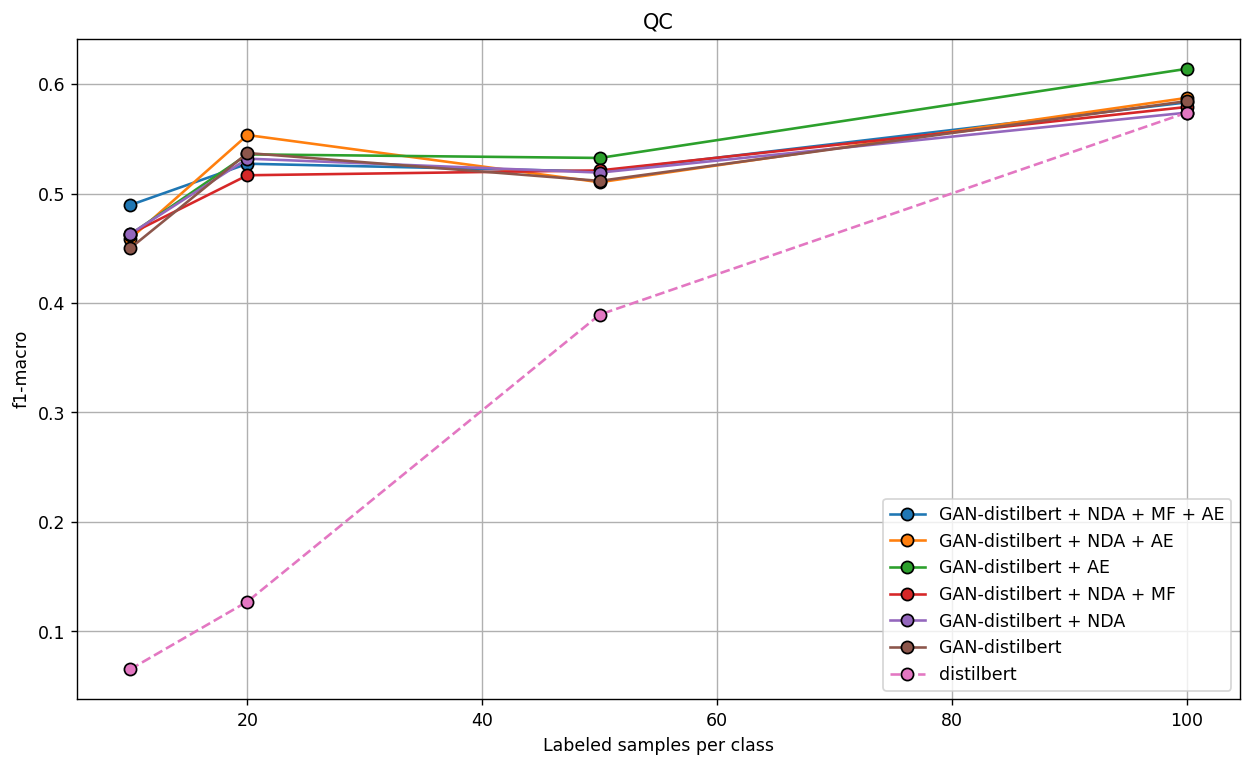

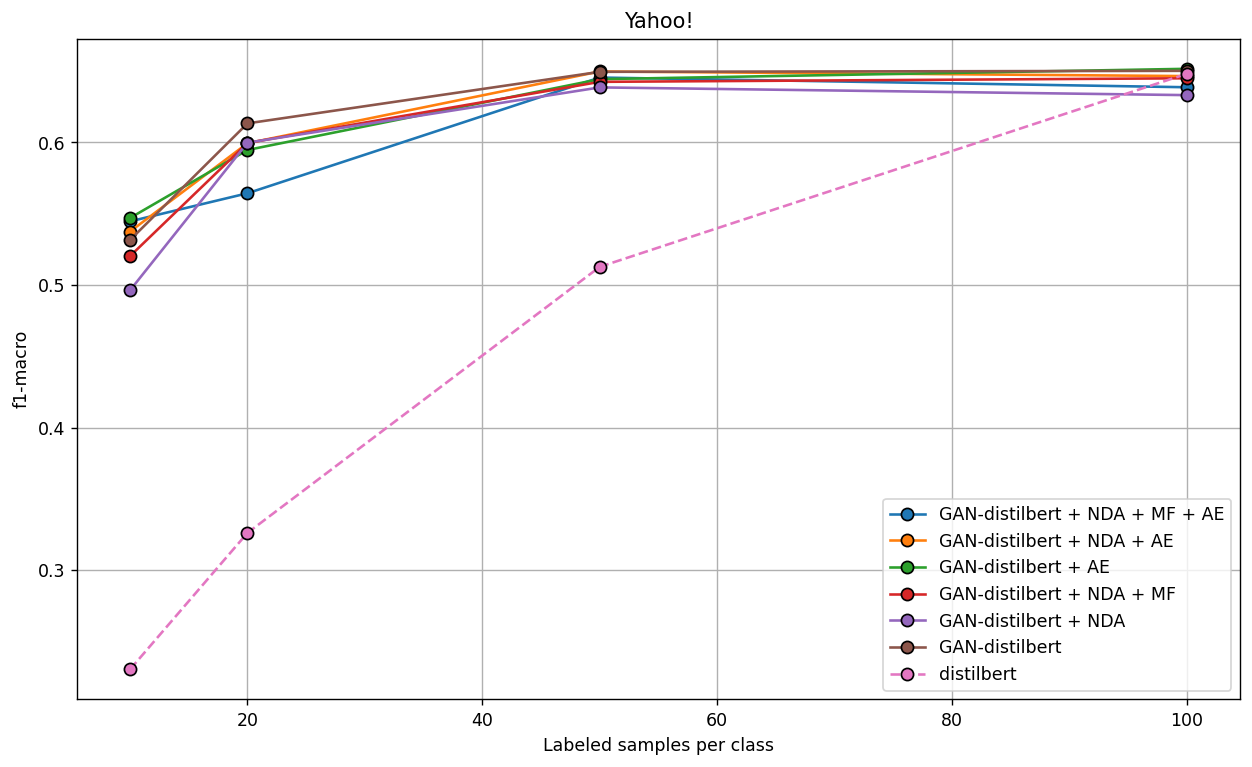

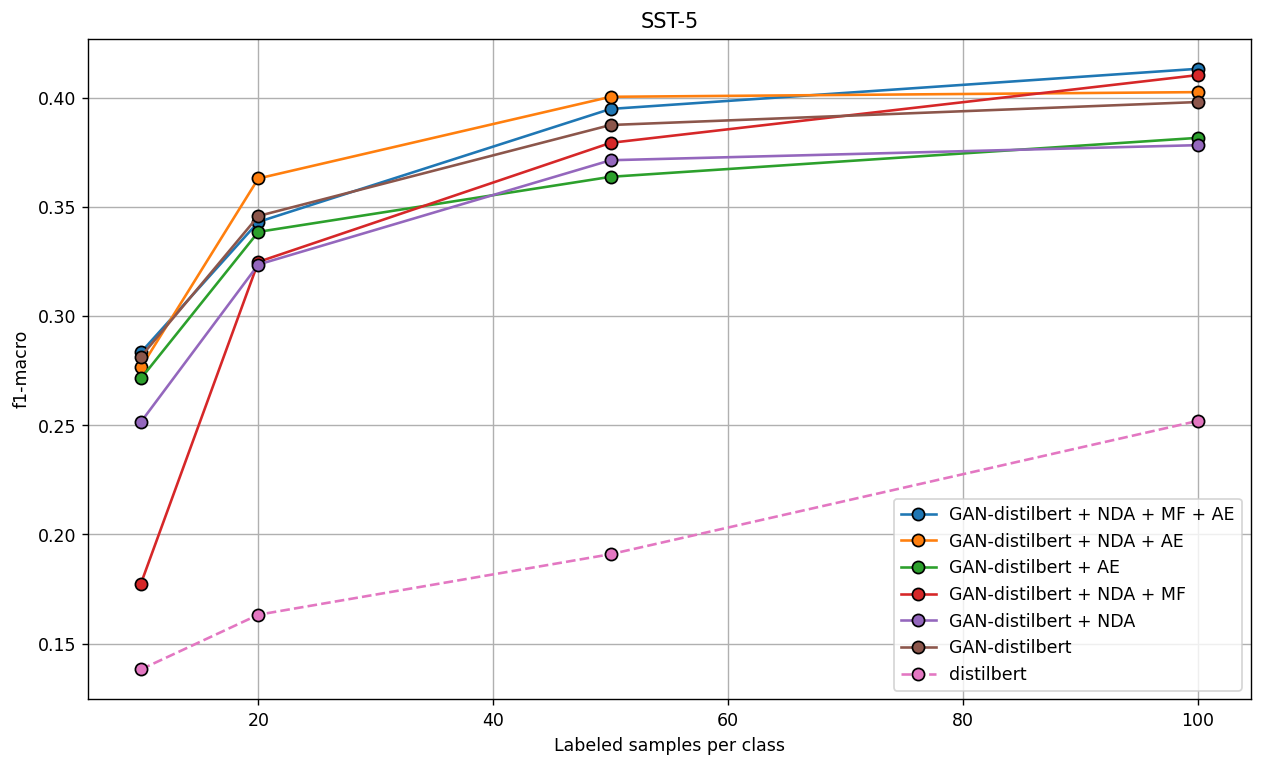

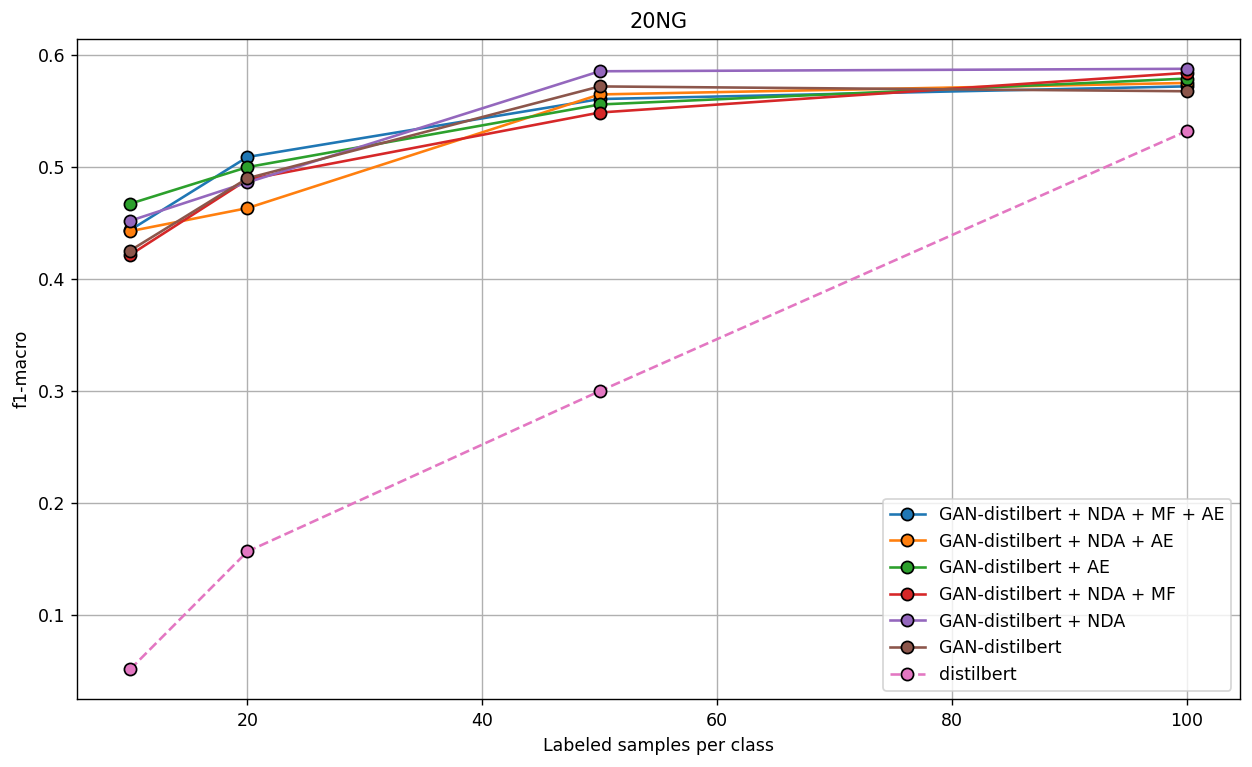

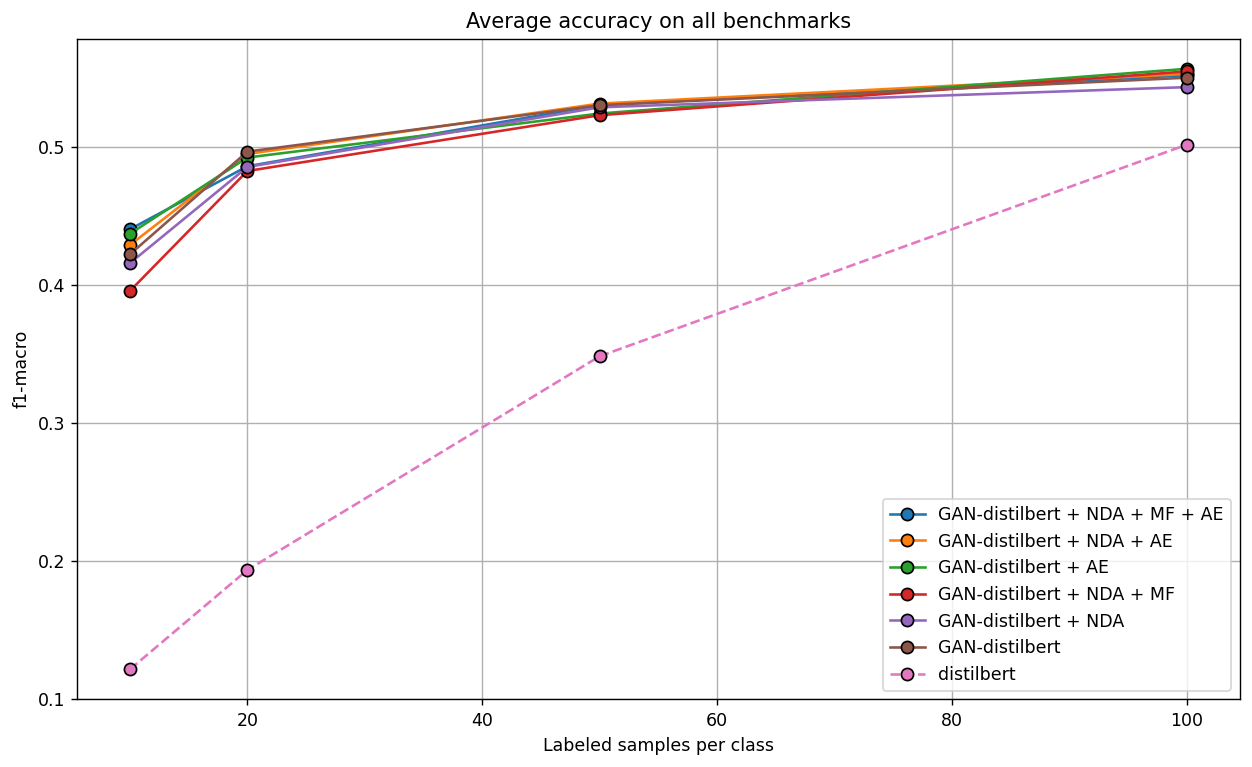

In [ ]:
import matplotlib.pyplot as plt


x = [10, 20, 50, 100]
set2name = {'qc': 'QC', 'sst': 'SST-5', 'imdb': 'IMDB', '20ng': '20NG', 'yahoo': 'Yahoo!'}

model2avg_f1 = {name:[] for name in df.NAME.unique()}
for _DATASET_NAME in df.dataset.unique():
    if _DATASET_NAME == 'imdb':
        continue
    tmp_df = df[df.dataset == _DATASET_NAME]
    avg_macro = []
    for avg in ['macro']:#, 'micro']:
        plt.figure(figsize=(12, 7), dpi=125)
        for NAME in df.NAME.unique():
            macro = tmp_df[tmp_df['NAME'] == NAME].groupby(['labeled']).agg({f'f1_{avg} (max)': 'mean'}) #.sort_values(['labeled'])
            model2avg_f1[NAME].append(macro)
            plt.plot(x, macro, marker='o' , label=NAME, linestyle=('--' if NAME == 'distilbert' else '-'), markersize=7, markeredgecolor='black')

        plt.legend()
        plt.ylabel(f'f1-{avg}')
        plt.xlabel('Labeled samples per class')
        plt.title(f'{set2name[_DATASET_NAME]}')
        plt.grid()

plt.figure(figsize=(12, 7), dpi=125)
for NAME in df.NAME.unique():
    macro = np.array(model2avg_f1[NAME]).mean(axis=0)
    plt.plot(x, macro, marker='o' , label=NAME, linestyle=('--' if NAME == 'distilbert' else '-'), markersize=7, markeredgecolor='black')
plt.legend()
plt.ylabel(f'f1-{avg}')
plt.xlabel('Labeled samples per class')
plt.title(f'Average accuracy on all benchmarks')
plt.grid()


In [ ]:
3

## Encoder quality

In [ ]:
df = stat_df[stat_df['Tags'].str.contains('base_encoder')]
subset = ['dataset', 'GAN', 'f1_macro (max)', 'f1_micro (max)',
          'accuracy (last)']
np.around(df.groupby(['dataset', 'config/model_name', 'labeled', 'GAN'])[subset].agg(['mean']), 2)

GAN f1_macro (max)  \
                                              mean           mean   
dataset config/model_name       labeled GAN                         
qc      albert-base-v2          1000.0  False  0.0           0.12   
                                        True   1.0           0.43   
                                2500.0  False  0.0           0.37   
                                        True   1.0           0.32   
        bert-base-cased         1000.0  False  0.0           0.18   
                                        True   1.0           0.56   
                                2500.0  False  0.0           0.51   
                                        True   1.0           0.59   
        distilbert-base-uncased 1000.0  False  0.0           0.16   
                                        True   1.0           0.53   
                                2500.0  False  0.0           0.40   
                                        True   1.0           0.54   
        distilroberta-base      1000.0  False  0.0           0.04   
                                        True   1.0           0.23   
                                2500.0  False  0.0           0.20   
                                        True   1.0           0.36   
        roberta-base            1000.0  False  0.0           0.02   
                                        True   1.0           0.02   
                                2500.0  False  0.0           0.10   
                                        True   1.0           0.16   
sst     albert-base-v2          250.0   False  0.0           0.08   
                                        True   1.0           0.30   
                                500.0   False  0.0           0.24   
                                        True   1.0           0.15   
        bert-base-cased         250.0   False  0.0           0.21   
                                        True   1.0           0.36   
                                500.0   False  0.0           0.23   
                                        True   1.0           0.37   
        distilbert-base-uncased 250.0   False  0.0           0.20   
                                        True   1.0           0.35   
                                500.0   False  0.0           0.23   
                                        True   1.0           0.38   
        distilroberta-base      250.0   False  0.0           0.09   
                                        True   1.0           0.32   
                                500.0   False  0.0           0.15   
                                        True   1.0           0.33   

                                              f1_micro (max) accuracy (last)  
                                                        mean            mean  
dataset config/model_name       labeled GAN                                   
qc      albert-base-v2          1000.0  False           0.55            0.55  
                                        True            0.77            0.77  
                                2500.0  False           0.73            0.73  
                                        True            0.70            0.70  
        bert-base-cased         1000.0  False           0.62            0.62  
                                        True            0.81            0.81  
                                2500.0  False           0.81            0.81  
                                        True            0.84            0.84  
        distilbert-base-uncased 1000.0  False           0.61            0.61  
                                        True            0.81            0.81  
                                2500.0  False           0.77            0.77  
                                        True            0.83            0.83  
        distilroberta-base      1000.0  False           0.39            0.39  
                                        True            0.62            0.62  
            

In [ ]:
times = pd.DataFrame(model2time)
for col in times:
    times[col] = times[col].apply(lambda x: x['time'])
np.around(times / 60, 1)

,roberta-base,distilroberta-base,albert-base-v2,bert-base-cased,distilbert-base-uncased
0,0.6,0.3,0.4,0.6,0.3
1,3.2,1.7,3.4,3.2,1.7
2,0.9,0.5,0.9,0.9,0.5
3,2.7,1.4,2.9,2.7,1.4


## Best model quality

In [182]:
df = stat_df[stat_df['Tags'].str.contains('labeled_best\"')]

def get_name(row):
    _model = row['config/model_name'].replace('-base-uncased', '').replace('-base-cased', '')
    if not row['GAN']:
        return _model
    name = f"GAN-{_model}"
    if row['conditional_gen']:
        name = f"C" + name 
    if row['NDA']:
        name = name + f" + NDA"
    if row['manifold']:
        name = name + f" + MF"
    if row['pretrained_gen']:
        name = name + f" + AE"
    return name

df['NAME'] = df.apply(get_name, axis=1)
df['NAME'].unique()

array(['GAN-bert', 'CGAN-bert + NDA + MF + AE', 'CGAN-bert + NDA + MF',
       'GAN-bert + AE', 'GAN-bert + NDA + MF', 'bert',
       'GAN-bert + NDA + MF + AE'], dtype=object)

In [183]:
subset = ['dataset', 'f1_macro (max)', 'accuracy (max)']
df = df[df.dataset != 'imdb']
df = df[(df.dataset != 'yahoo') | (df.labeled_proportion != 0.3)]
# np.around(df[df.dataset=='imdb'].groupby(['dataset', 'labeled_proportion', 'NAME'])[subset].agg(['mean', 'count']), 3)

In [184]:
# np.around(df.groupby(['dataset', 'labeled_proportion', 'NAME'])[subset].agg(['mean', 'count']), 3)

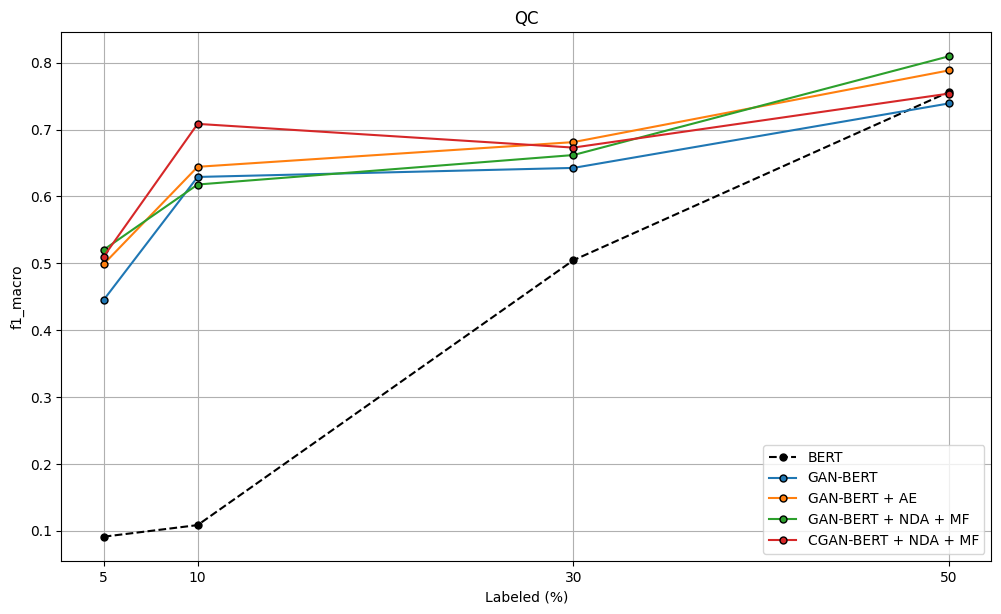

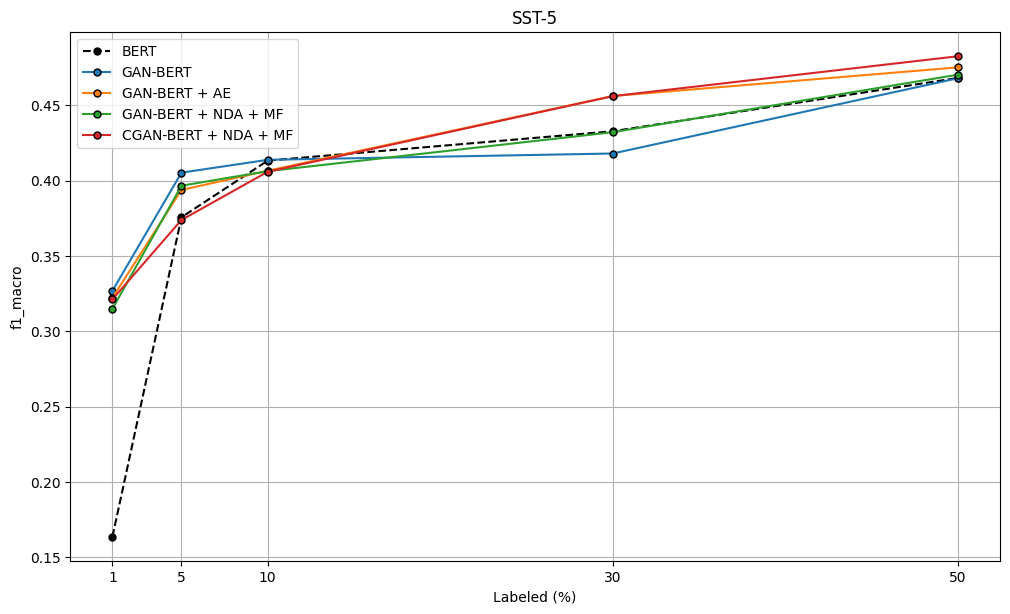

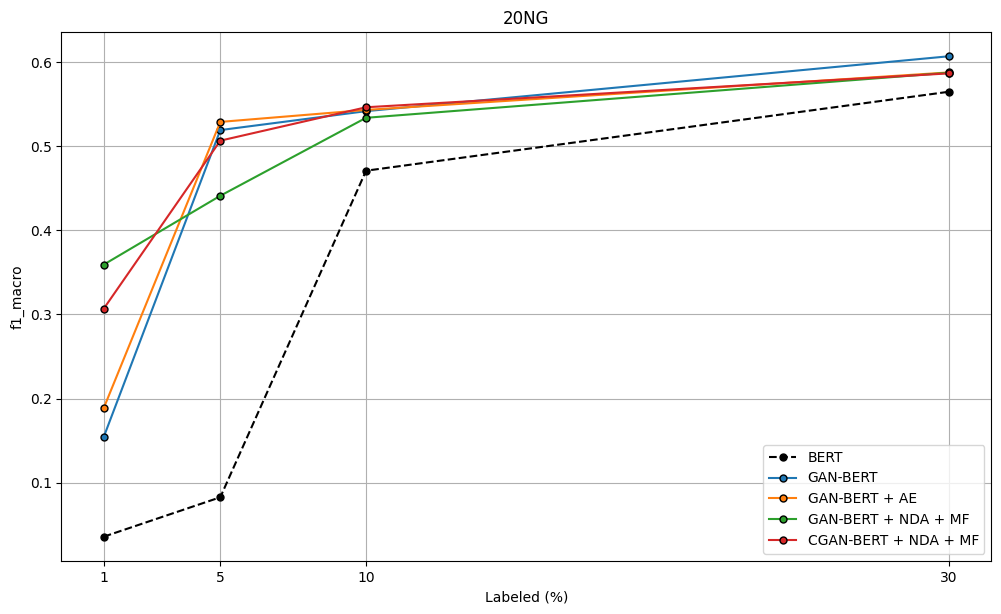

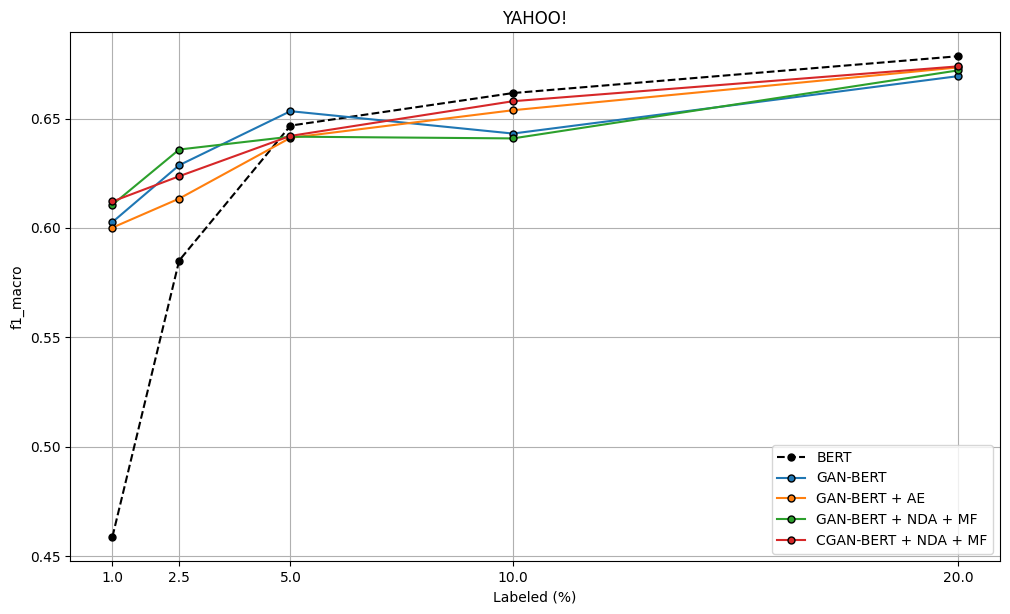

In [186]:
import matplotlib.pyplot as plt


set2name = {'qc': 'QC', 'sst': 'SST-5', '20ng': '20NG', 'yahoo': 'Yahoo!'}
NAMES = ['bert', 'GAN-bert', 'GAN-bert + AE', 'GAN-bert + NDA + MF', 'CGAN-bert + NDA + MF']
# NAMES = df.NAME.unique()
set2metric = {'qc': 'f1_macro', 'sst': 'f1_macro', 'imdb': 'f1_macro', '20ng': 'f1_macro', 'yahoo': 'f1_macro'}
model2avg_f1 = {name:[] for name in df.NAME.unique()}
for _SET in set2name:
    tmp_df = df[df.dataset == _SET]
    avg_macro = []
    plt.figure(figsize=(12, 7), dpi=100)
    for NAME in NAMES:
        macro = tmp_df[tmp_df['NAME'] == NAME].groupby(['labeled_proportion']).agg({f'{set2metric[_SET]} (max)': 'mean'}).sort_values(['labeled_proportion'])
        model2avg_f1[NAME].append(macro)
        plt.plot(macro.index * 100, macro, marker='o' , label=NAME.upper(), 
                 linestyle=('--' if NAME == 'bert' else '-'), markersize=5, 
                 markeredgecolor='black', color=('black' if NAME == 'bert' else None))
    plt.xticks(macro.index * 100)
    plt.legend()
    plt.ylabel(f'{set2metric[_SET]}')
    plt.xlabel('Labeled (%)')
    plt.title(f'{set2name[_SET].upper()}')
    plt.grid()

## Best model quality balanced

In [12]:
df = stat_df[stat_df['Tags'].str.contains('labeled_best_balanced')]

def get_name(row):
    _model = row['config/model_name'].replace('-base-uncased', '').replace('-base-cased', '')
    if not row['GAN']:
        return _model
    name = f"GAN-{_model}"
    if row['conditional_gen']:
        name = f"C" + name 
    if row['NDA']:
        name = name + f" + NDA"
    if row['manifold']:
        name = name + f" + MF"
    if row['pretrained_gen']:
        name = name + f" + AE"
    return name

df['NAME'] = df.apply(get_name, axis=1)
df['NAME'].unique()

array(['GAN-bert', 'bert', 'CGAN-bert + NDA + MF + AE',
       'CGAN-bert + NDA + MF', 'GAN-bert + NDA + MF', 'GAN-bert + AE'],
      dtype=object)

In [13]:
subset = ['dataset', 'GAN', 'f1_macro (max)', 'accuracy (max)']
# np.around(df.groupby(['dataset', 'config/labeled_per_class', 'NAME'])[subset].agg(['mean', 'count']), 3)

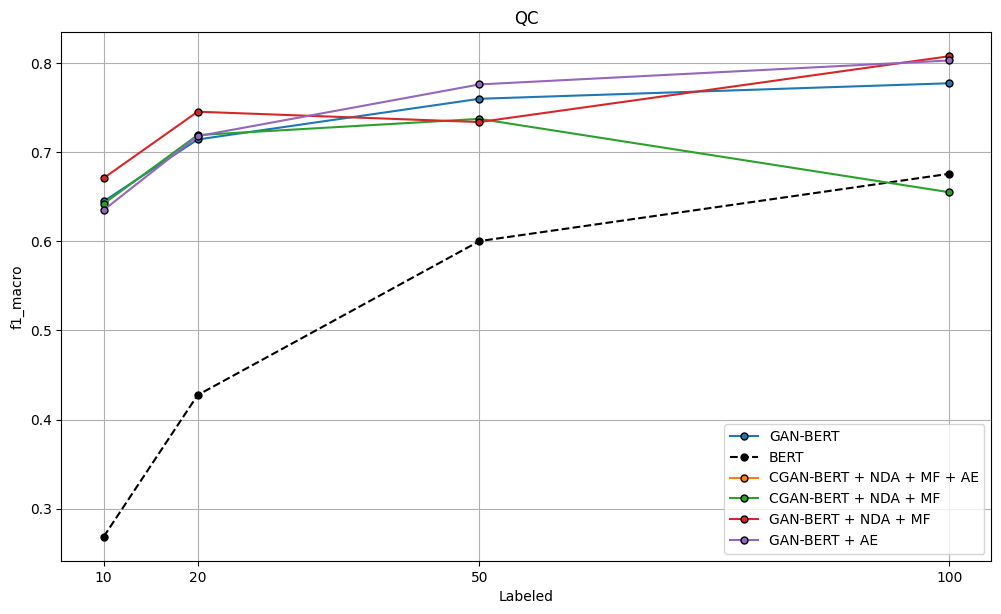

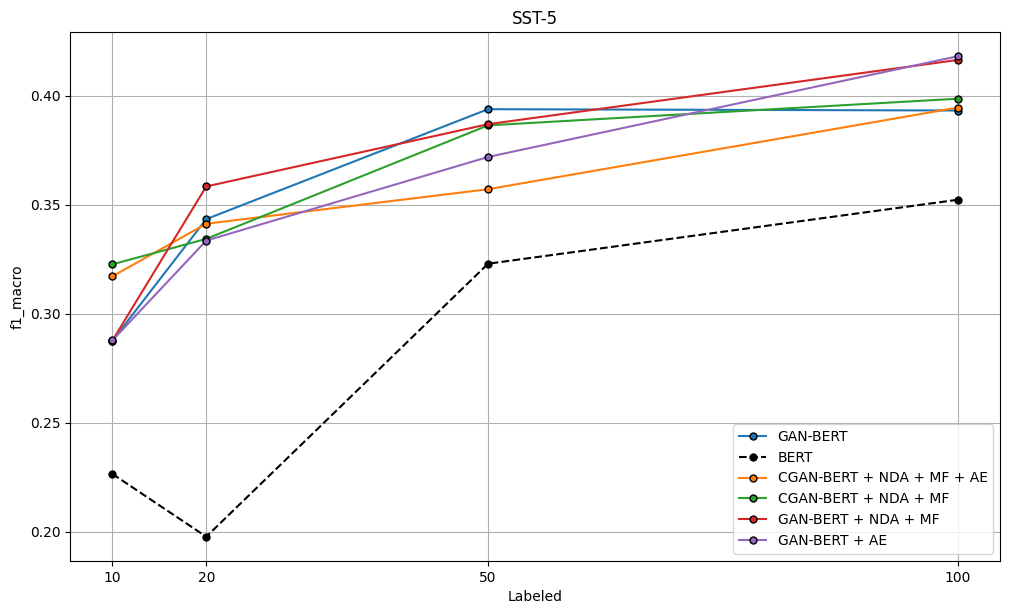

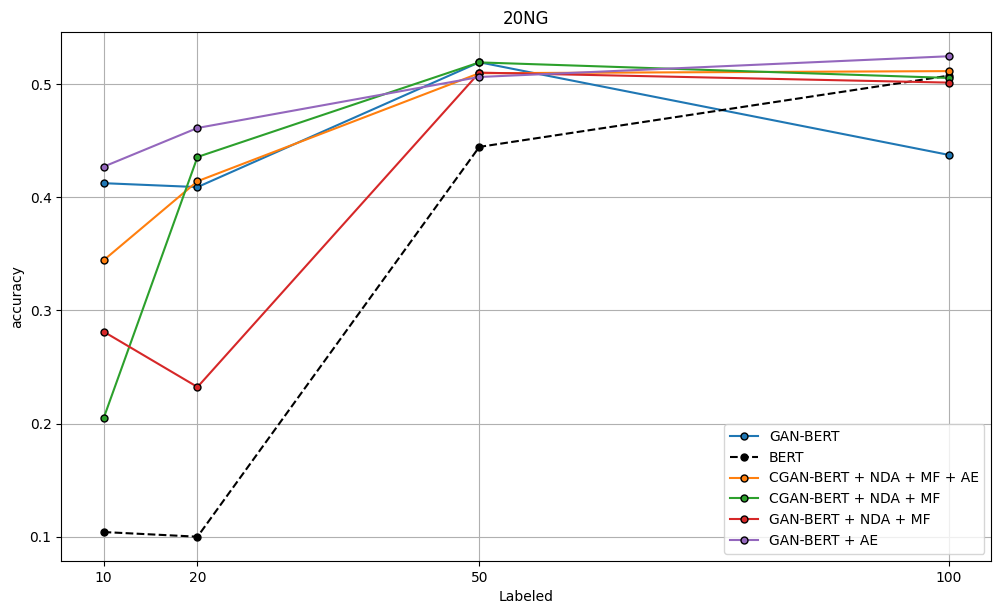

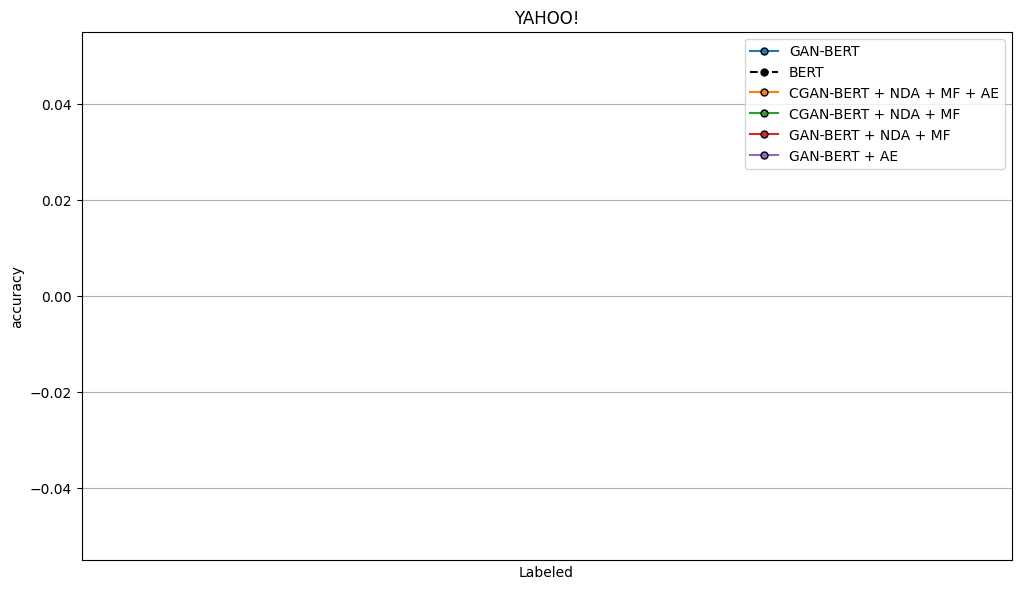

In [14]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


set2name = {'qc': 'QC', 'sst': 'SST-5', '20ng': '20NG', 'yahoo': 'Yahoo!'}
# NAMES = ['bert', 'GAN-bert', 'GAN-bert + AE', 'GAN-bert + NDA + MF', 'CGAN-bert + NDA + MF']
NAMES = df.NAME.unique()
set2metric = {'qc': 'f1_macro', 'sst': 'f1_macro', 'imdb': 'f1_macro', '20ng': 'accuracy', 'yahoo': 'accuracy'}
model2avg_f1 = {name:[] for name in df.NAME.unique()}
for _SET in set2name:
    tmp_df = df[df.dataset == _SET]
    avg_macro = []
    plt.figure(figsize=(12, 7), dpi=100)
    for NAME in NAMES:
        macro = tmp_df[tmp_df['NAME'] == NAME].groupby(['config/labeled_per_class']).agg({f'{set2metric[_SET]} (max)': 'mean'})
        macro = macro.sort_values(['config/labeled_per_class'])
        macro = macro.iloc[:-1]
        model2avg_f1[NAME].append(macro)
        plt.plot(macro.index, macro, marker='o' , label=NAME.upper(), 
                 linestyle=('--' if NAME == 'bert' else '-'), markersize=5, 
                 markeredgecolor='black', color=('black' if NAME == 'bert' else None))
        plt.xticks(macro.index)

    plt.legend()
    plt.ylabel(f'{set2metric[_SET]}')
    # plt.xlabel('Labeled proportion')
    plt.xlabel('Labeled')
    plt.title(f'{set2name[_SET].upper()}')
    plt.grid()

## (Un)conditional GAN

In [194]:
df = stat_df[stat_df['Tags'].str.contains('generator_type')]

def get_name(row):
    _model = row['config/model_name'].replace('-base-uncased', '').replace('-base-cased', '')
    if not row['GAN']:
        return _model
    name = f"GAN-{_model}"
    if row['conditional_gen']:
        name = f"C" + name 
    if row['NDA']:
        name = name + f" + NDA"
    if row['manifold']:
        name = name + f" + MF"
    if row['pretrained_gen']:
        name = name + f" + AE"
    return name

df['NAME'] = df.apply(get_name, axis=1)
df['NAME'].unique()

array(['CGAN-bert + AE', 'GAN-bert + AE', 'CGAN-bert', 'GAN-bert'],
      dtype=object)

In [65]:
subset = ['dataset', 'f1_macro (max)', 'accuracy (max)']
np.around(df.groupby(['dataset', 'NAME'])[subset].agg(['mean', 'count']), 2)

f1_macro (max)       accuracy (max)      
                                 mean count           mean count
dataset NAME                                                    
qc      CGAN-bert                0.58     8           0.82     8
        CGAN-bert + AE           0.62     8           0.83     8
        GAN-bert                 0.60     8           0.82     8
        GAN-bert + AE            0.60     8           0.81     8
sst     CGAN-bert                0.42     8           0.46     8
        CGAN-bert + AE           0.43     8           0.46     8
        GAN-bert                 0.42     9           0.47     9
        GAN-bert + AE            0.41     8           0.45     8

## Error analysis

## Representations space research

### Discriminator backbone

In [199]:
from data_loader import generate_data_loader
transformer = exp.discriminator.backbone
transformer.to(device)
transformer.eval()
states_list = []
_labels = []
local_data_loader = generate_data_loader(exp.labeled_examples, 
                                        exp.labeled_masks, 
                                        label_map=exp.label2id, 
                                        batch_size=64, 
                                        tokenizer=exp.tokenizer, 
                                        max_seq_length=exp.config['max_seq_length'],
                                        do_shuffle=False, 
                                        balance_label_examples=exp.config['apply_balance'],
                                        return_ids=False)
for batch in tqdm_notebook(local_data_loader):
    input_ids = batch[0].to(device)
    input_mask = batch[1].to(device)
    labels = batch[2]
    trf_output = transformer(input_ids, attention_mask=input_mask)
    hidden_states = trf_output.last_hidden_state[:, 0, :]
    states_list.append(hidden_states.cpu().detach().numpy())
    _labels.extend(labels.numpy())
_states = np.vstack(states_list)
emb_test_df = pd.DataFrame(_states)
emb_test_df['label'] = _labels

  0%|          | 0/18 [00:00<?, ?it/s]

### Generator representations

In [200]:
N = 50000
generator = exp.generator
generator.eval()
use_dist_params = False

noise = np.random.normal(0, 10, size=(N, 100)).astype('float32')

noise = torch.from_numpy(noise).to(device)
if CONFIG['conditional_generator']:
    if not use_dist_params:
        rand_labels = np.random.randint(1, CONFIG['num_labels'], 
                                        N, dtype='int')
    rand_labels = torch.from_numpy(rand_labels).to(device)
    generated_embs = generator(noise, rand_labels)
    rand_labels = rand_labels.cpu().numpy()
else:
    generated_embs = generator(noise)
generated_embs.shape
exp.discriminator.eval()
_, logits, _probs, _  = exp.discriminator(external_states=generated_embs)

In [201]:
probs = _probs.cpu().detach().numpy()[:, 1: ]
np_probs = probs[:, :-1]


if CONFIG['conditional_generator']:
    indx = np.argmax(probs, axis=1) == rand_labels
else:
    indx = np.argmax(probs, axis=1) != CONFIG['num_labels'] - 1
    # indx = np.argmax(probs, axis=1) != -1
cheat_embs = generated_embs[indx, :]
cheat_label = np.argmax(np_probs[indx], axis=1) + 1
cheat_embs.shape, len(cheat_label)

(torch.Size([880, 768]), 880)

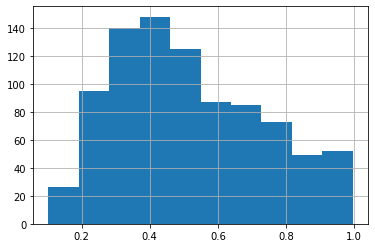

In [202]:
import matplotlib.pyplot as plt

plt.hist(np_probs[indx].max(axis=1))
plt.grid()
pass

In [203]:
cut_of = 0.8
indx = np_probs[indx].max(axis=1) > cut_of
cheat_embs = cheat_embs[indx, :]
cheat_label = cheat_label[indx]

print('Unique labels', len(np.unique(cheat_label)))
cheat_embs.shape, len(cheat_label)

Unique labels 16


(torch.Size([116, 768]), 116)

In [204]:
# label2count = dict(exp.labeled_df.label.value_counts())
# generated_embs = cheat_embs.cpu().detach().numpy()
# X_embedded = TSNE(n_components=2, learning_rate='auto',
#                   init='random').fit_transform(generated_embs)
# draw_df = pd.DataFrame(X_embedded, columns=['dimension 1', 'dimension 2'])
# draw_df['prdicted label'] = cheat_label 
# # draw_df['prdicted label'] = draw_df['prdicted label'].apply(lambda x: f'{x} : {str(label_list[x])}  ({str(label2count[label_list[x]])})')
# draw_df['prdicted label'] = draw_df['prdicted label'].astype('str')

In [205]:
# generated_embs = generated_embs.cpu().detach().numpy()
generated_embs = cheat_embs.cpu().detach().numpy()
generated_embs.shape

(116, 768)

In [206]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(np.vstack([_states, generated_embs]))
_draw_df = pd.DataFrame(X_embedded, columns=['dimension 1', 'dimension 2'])
_draw_df['label'] = _labels +  cheat_label.tolist()
_draw_df['label'] = _draw_df['label'].astype('str')
_draw_df['is_generated'] = ['no'] * _states.shape[0] + ['yes'] * generated_embs.shape[0]
_draw_df['weight'] = [ 500 ] * _states.shape[0] + [ 1000 ] * generated_embs.shape[0]

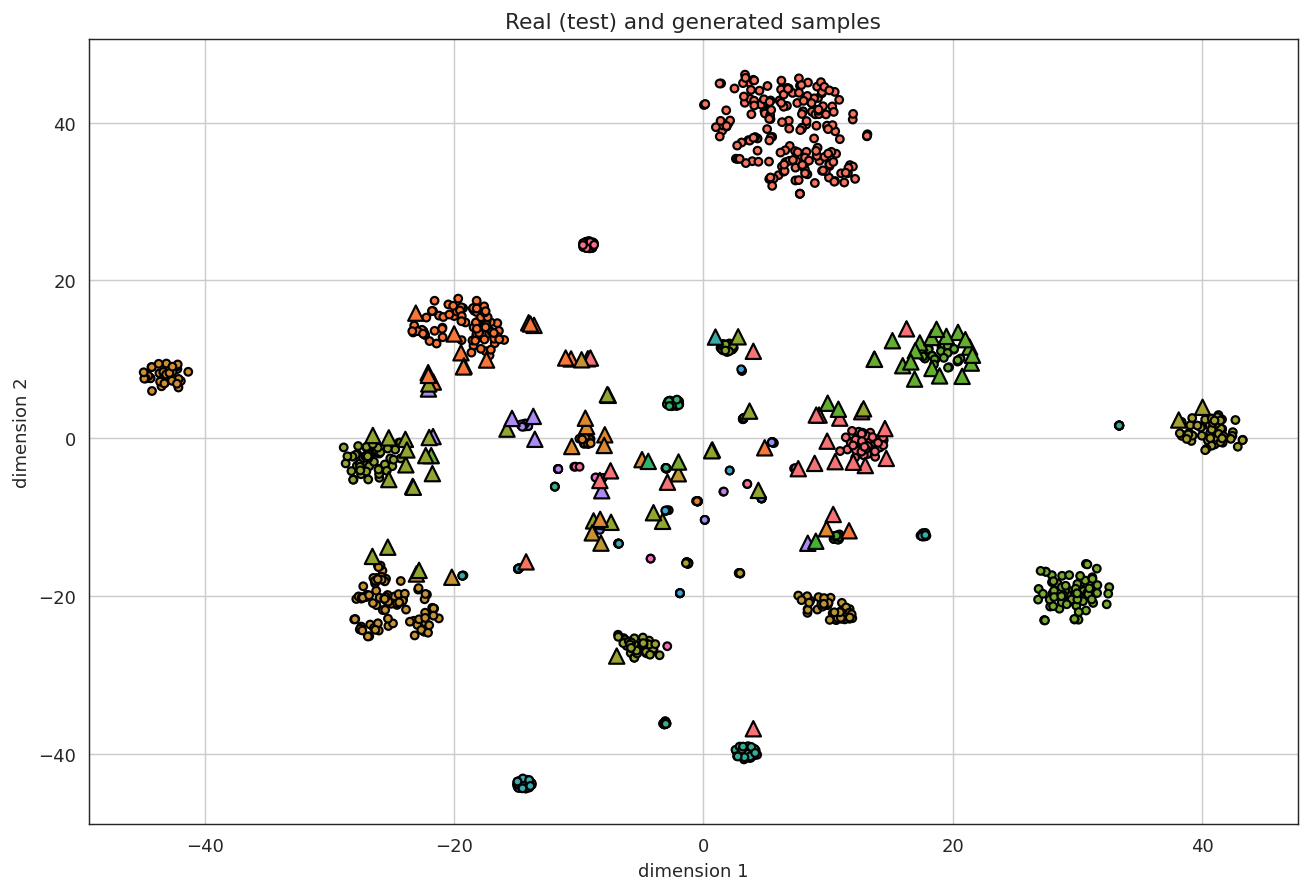

In [207]:
sns.set_style("white")
plt.figure(figsize=(12, 8),  dpi=130)
markers = {"yes": "^", "no": "o"}
_ = sns.scatterplot(x='dimension 1', y='dimension 2', 
                hue='label',  style='is_generated',
                data=_draw_df, markers=markers,
                edgecolor='black',
                linewidth=1.2,
                legend=None,
                size="weight",
                s=100
)
plt.grid()
plt.title('Real (test) and generated samples');